In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb pandas numpy matplotlib seaborn scikit-learn mlflow statsmodels

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.0/677.0 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 14.2 MB/s eta 0:00:00


In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 535MB/s]


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

# Basic info about datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)
print("Features shape:", features.shape)

# Display first few rows
train.head()

Train shape: (421570, 5)
Test shape: (115064, 4)
Stores shape: (45, 3)
Features shape: (8190, 12)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
# Check data types and missing values
def explore_dataset(df, name):
    print(f"\n=== {name} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nUnique values per column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()}")

explore_dataset(train, "Train")
explore_dataset(test, "Test")
explore_dataset(stores, "Stores")
explore_dataset(features, "Features")



=== Train Dataset ===
Shape: (421570, 5)

Data types:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

Missing values:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

Unique values per column:
Store: 45
Dept: 81
Date: 143
Weekly_Sales: 359464
IsHoliday: 2

=== Test Dataset ===
Shape: (115064, 4)

Data types:
Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object

Missing values:
Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

Unique values per column:
Store: 45
Dept: 81
Date: 39
IsHoliday: 2

=== Stores Dataset ===
Shape: (45, 3)

Data types:
Store     int64
Type     object
Size      int64
dtype: object

Missing values:
Store    0
Type     0
Size     0
dtype: int64

Unique values per column:
Store: 45
Type: 3
Size: 40

=== Features Dataset ===
Shape: (8190, 12)

Data types:
Store  

In [8]:
# Convert Date column to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Time range analysis
print("Train date range:", train['Date'].min(), "to", train['Date'].max())
print("Test date range:", test['Date'].min(), "to", test['Date'].max())
print("Features date range:", features['Date'].min(), "to", features['Date'].max())

# Check for date gaps
train_dates = sorted(train['Date'].unique())
date_gaps = []
for i in range(1, len(train_dates)):
    gap = (train_dates[i] - train_dates[i-1]).days
    if gap > 7:  # More than a week
        date_gaps.append((train_dates[i-1], train_dates[i], gap))

print("Date gaps found:", len(date_gaps))

Train date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Test date range: 2012-11-02 00:00:00 to 2013-07-26 00:00:00
Features date range: 2010-02-05 00:00:00 to 2013-07-26 00:00:00
Date gaps found: 0


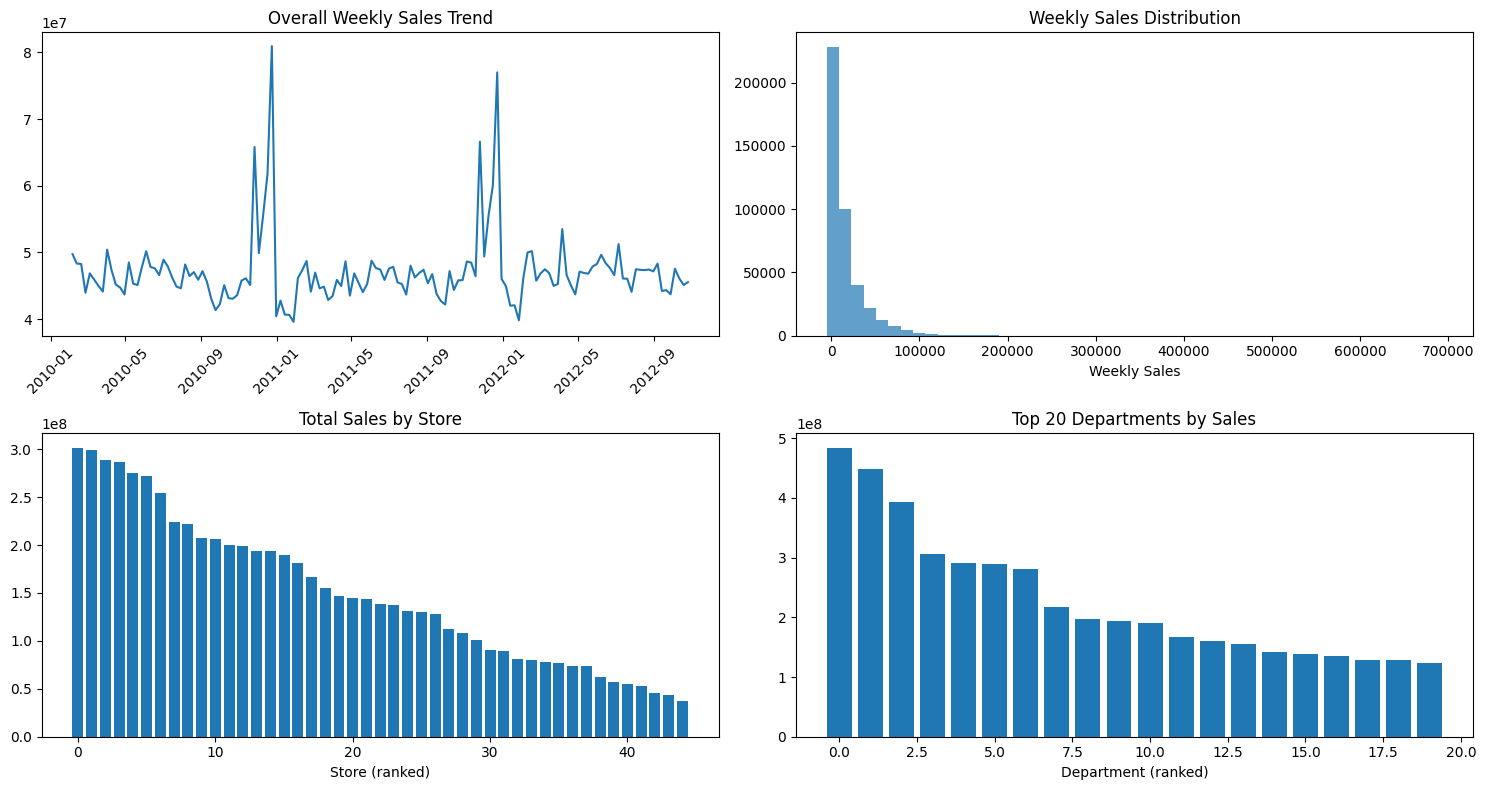

In [9]:
# Overall sales trends
plt.figure(figsize=(15, 8))

# Aggregate weekly sales
weekly_sales = train.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.subplot(2, 2, 1)
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'])
plt.title('Overall Weekly Sales Trend')
plt.xticks(rotation=45)

# Sales distribution
plt.subplot(2, 2, 2)
plt.hist(train['Weekly_Sales'], bins=50, alpha=0.7)
plt.title('Weekly Sales Distribution')
plt.xlabel('Weekly Sales')

# Sales by store
plt.subplot(2, 2, 3)
store_sales = train.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
plt.bar(range(len(store_sales)), store_sales.values)
plt.title('Total Sales by Store')
plt.xlabel('Store (ranked)')

# Sales by department
plt.subplot(2, 2, 4)
dept_sales = train.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(20)
plt.bar(range(len(dept_sales)), dept_sales.values)
plt.title('Top 20 Departments by Sales')
plt.xlabel('Department (ranked)')

plt.tight_layout()
plt.show()

Train columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month', 'Week', 'DayOfYear', 'Quarter']
Features columns: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
Train_features columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Year', 'Month', 'Week', 'DayOfYear', 'Quarter', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y']
Train_features shape: (421570, 20)
Holiday-related columns found: ['IsHoliday_x', 'IsHoliday_y']


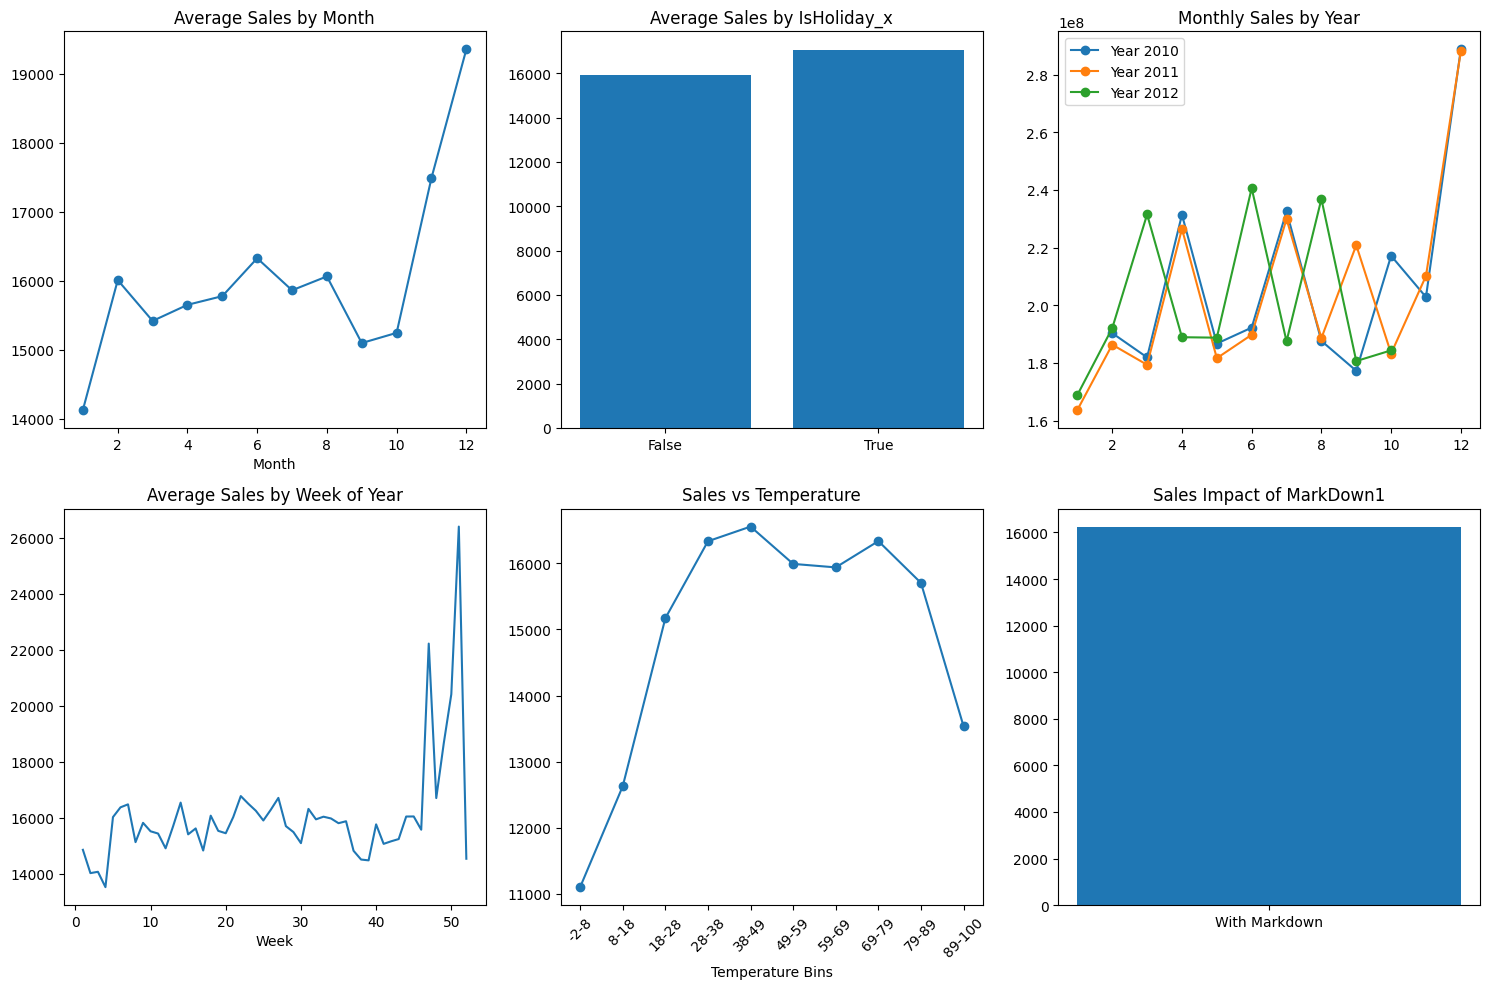

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add time features
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.isocalendar().week
train['DayOfYear'] = train['Date'].dt.dayofyear

# Debug: Check what columns are available
print("Train columns:", train.columns.tolist())
print("Features columns:", features.columns.tolist())

# Merge with features to get holiday information
train_features = train.merge(features, on=['Store', 'Date'], how='left')

# Debug: Check merged dataframe columns
print("Train_features columns:", train_features.columns.tolist())
print("Train_features shape:", train_features.shape)

# Check for holiday-related columns
holiday_columns = [col for col in train_features.columns if 'holiday' in col.lower()]
print("Holiday-related columns found:", holiday_columns)

# Holiday impact analysis
plt.figure(figsize=(15, 10))

# Monthly seasonality
plt.subplot(2, 3, 1)
monthly_sales = train.groupby('Month')['Weekly_Sales'].mean()
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title('Average Sales by Month')
plt.xlabel('Month')

# Holiday vs Non-holiday sales (with error handling)
plt.subplot(2, 3, 2)
if 'IsHoliday' in train_features.columns:
    holiday_sales = train_features.groupby('IsHoliday')['Weekly_Sales'].mean()
    labels = ['Non-Holiday', 'Holiday'] if len(holiday_sales) == 2 else [f'Group_{i}' for i in range(len(holiday_sales))]
    plt.bar(labels, holiday_sales.values)
    plt.title('Average Sales: Holiday vs Non-Holiday')
elif len(holiday_columns) > 0:
    # Use the first available holiday column
    holiday_col = holiday_columns[0]
    holiday_sales = train_features.groupby(holiday_col)['Weekly_Sales'].mean()
    plt.bar(range(len(holiday_sales)), holiday_sales.values)
    plt.title(f'Average Sales by {holiday_col}')
    plt.xticks(range(len(holiday_sales)), holiday_sales.index)
else:
    # If no holiday data available, show a message
    plt.text(0.5, 0.5, 'No Holiday Data Available',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Holiday Analysis - No Data')

# Year-over-year comparison
plt.subplot(2, 3, 3)
yearly_sales = train.groupby(['Year', 'Month'])['Weekly_Sales'].sum().unstack(level=0)
for year in yearly_sales.columns:
    plt.plot(yearly_sales.index, yearly_sales[year], marker='o', label=f'Year {year}')
plt.title('Monthly Sales by Year')
plt.legend()

# Weekly patterns
plt.subplot(2, 3, 4)
weekly_pattern = train.groupby('Week')['Weekly_Sales'].mean()
plt.plot(weekly_pattern.index, weekly_pattern.values)
plt.title('Average Sales by Week of Year')
plt.xlabel('Week')

# Temperature impact (if available)
plt.subplot(2, 3, 5)
if 'Temperature' in train_features.columns:
    # Remove NaN values for temperature analysis
    temp_data = train_features.dropna(subset=['Temperature'])
    if len(temp_data) > 0:
        temp_sales = temp_data.groupby(pd.cut(temp_data['Temperature'], bins=10))['Weekly_Sales'].mean()
        plt.plot(range(len(temp_sales)), temp_sales.values, marker='o')
        plt.title('Sales vs Temperature')
        plt.xlabel('Temperature Bins')
        plt.xticks(range(len(temp_sales)), [f'{int(x.left)}-{int(x.right)}' for x in temp_sales.index], rotation=45)
    else:
        plt.text(0.5, 0.5, 'No Temperature Data Available',
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
        plt.title('Temperature Analysis - No Data')
else:
    plt.text(0.5, 0.5, 'Temperature Column Not Found',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.title('Temperature Analysis - Column Missing')

# Additional analysis if markdown data is available
plt.subplot(2, 3, 6)
markdown_cols = [col for col in train_features.columns if 'markdown' in col.lower()]
if markdown_cols:
    # Analyze impact of markdowns
    markdown_col = markdown_cols[0]  # Use first markdown column
    markdown_data = train_features.dropna(subset=[markdown_col])
    if len(markdown_data) > 0:
        # Compare sales with and without markdowns
        with_markdown = markdown_data[markdown_data[markdown_col] > 0]['Weekly_Sales'].mean()
        without_markdown = markdown_data[markdown_data[markdown_col] == 0]['Weekly_Sales'].mean()

        plt.bar(['Without Markdown', 'With Markdown'], [without_markdown, with_markdown])
        plt.title(f'Sales Impact of {markdown_col}')
    else:
        plt.text(0.5, 0.5, 'No Markdown Data Available',
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
        plt.title('Markdown Analysis - No Data')
else:
    plt.text(0.5, 0.5, 'No Markdown Columns Found',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.title('Markdown Analysis - No Columns')

plt.tight_layout()
plt.show()

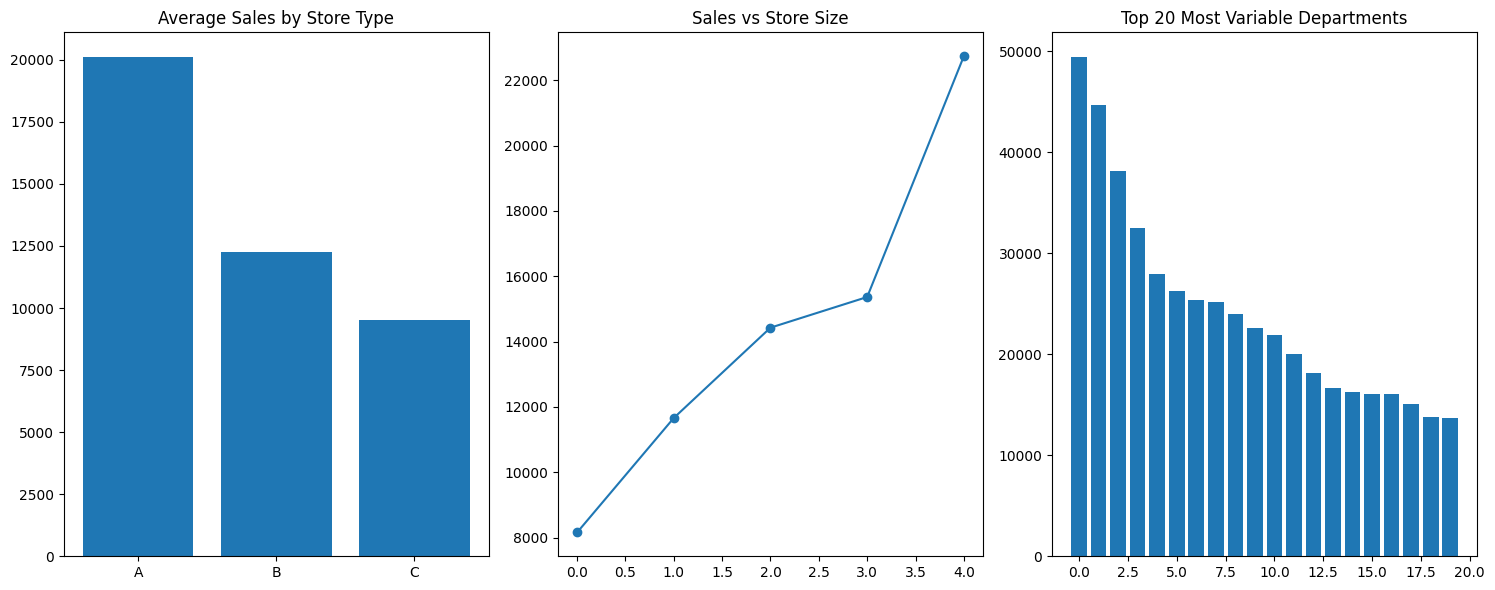

In [12]:
# Merge with store information
train_stores = train.merge(stores, on='Store', how='left')

# Store type analysis
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
type_sales = train_stores.groupby('Type')['Weekly_Sales'].mean()
plt.bar(type_sales.index, type_sales.values)
plt.title('Average Sales by Store Type')

plt.subplot(1, 3, 2)
size_sales = train_stores.groupby(pd.cut(train_stores['Size'], bins=5))['Weekly_Sales'].mean()
plt.plot(range(len(size_sales)), size_sales.values, marker='o')
plt.title('Sales vs Store Size')

# Department performance variability
plt.subplot(1, 3, 3)
dept_variability = train.groupby('Dept')['Weekly_Sales'].std().sort_values(ascending=False).head(20)
plt.bar(range(len(dept_variability)), dept_variability.values)
plt.title('Top 20 Most Variable Departments')

plt.tight_layout()
plt.show()

In [13]:
# Negative sales analysis
negative_sales = train[train['Weekly_Sales'] < 0]
print(f"Negative sales records: {len(negative_sales)} ({len(negative_sales)/len(train)*100:.2f}%)")

if len(negative_sales) > 0:
    print("Negative sales by department:")
    print(negative_sales.groupby('Dept')['Weekly_Sales'].count().sort_values(ascending=False).head(10))

# Zero sales analysis
zero_sales = train[train['Weekly_Sales'] == 0]
print(f"Zero sales records: {len(zero_sales)} ({len(zero_sales)/len(train)*100:.2f}%)")

# Missing data patterns in features
if 'MarkDown1' in features.columns:
    markdown_cols = [col for col in features.columns if 'MarkDown' in col]
    markdown_missing = features[markdown_cols].isnull().sum()
    print("Missing markdown data:")
    print(markdown_missing)

Negative sales records: 1285 (0.30%)
Negative sales by department:
Dept
47    254
18    180
54    146
19     87
94     77
80     68
49     67
59     44
72     34
78     33
Name: Weekly_Sales, dtype: int64
Zero sales records: 73 (0.02%)
Missing markdown data:
MarkDown1    4158
MarkDown2    5269
MarkDown3    4577
MarkDown4    4726
MarkDown5    4140
dtype: int64


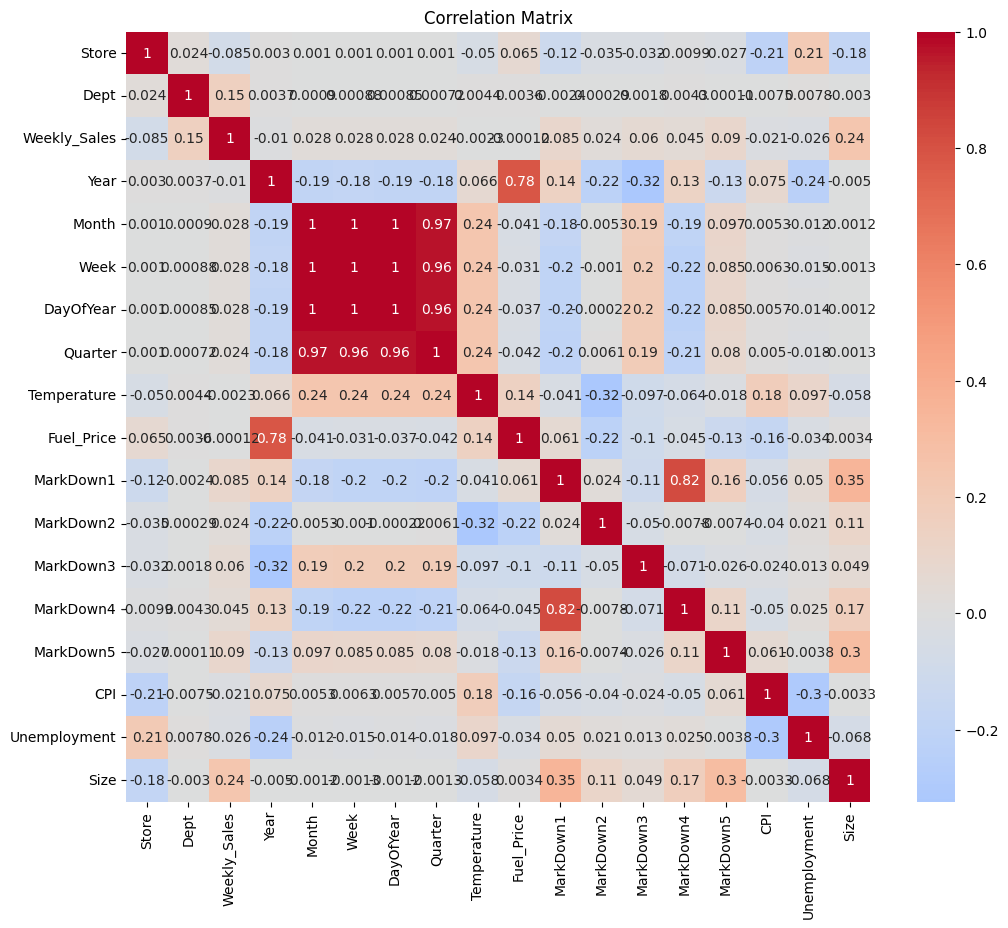

Correlations with Weekly_Sales:
Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
MarkDown5       0.090362
MarkDown1       0.085251
MarkDown3       0.060385
MarkDown4       0.045414
Month           0.028409
DayOfYear       0.027713
Week            0.027673
MarkDown2       0.024130
Quarter         0.023838
Fuel_Price     -0.000120
Temperature    -0.002312
Year           -0.010111
CPI            -0.020921
Unemployment   -0.025864
Store          -0.085195
Name: Weekly_Sales, dtype: float64


In [14]:
# Correlation with external factors
if len(train_features.columns) > len(train.columns):
    numeric_cols = train_features.select_dtypes(include=[np.number]).columns
    correlation_matrix = train_features[numeric_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

    # Focus on Weekly_Sales correlations
    sales_corr = correlation_matrix['Weekly_Sales'].sort_values(ascending=False)
    print("Correlations with Weekly_Sales:")
    print(sales_corr)

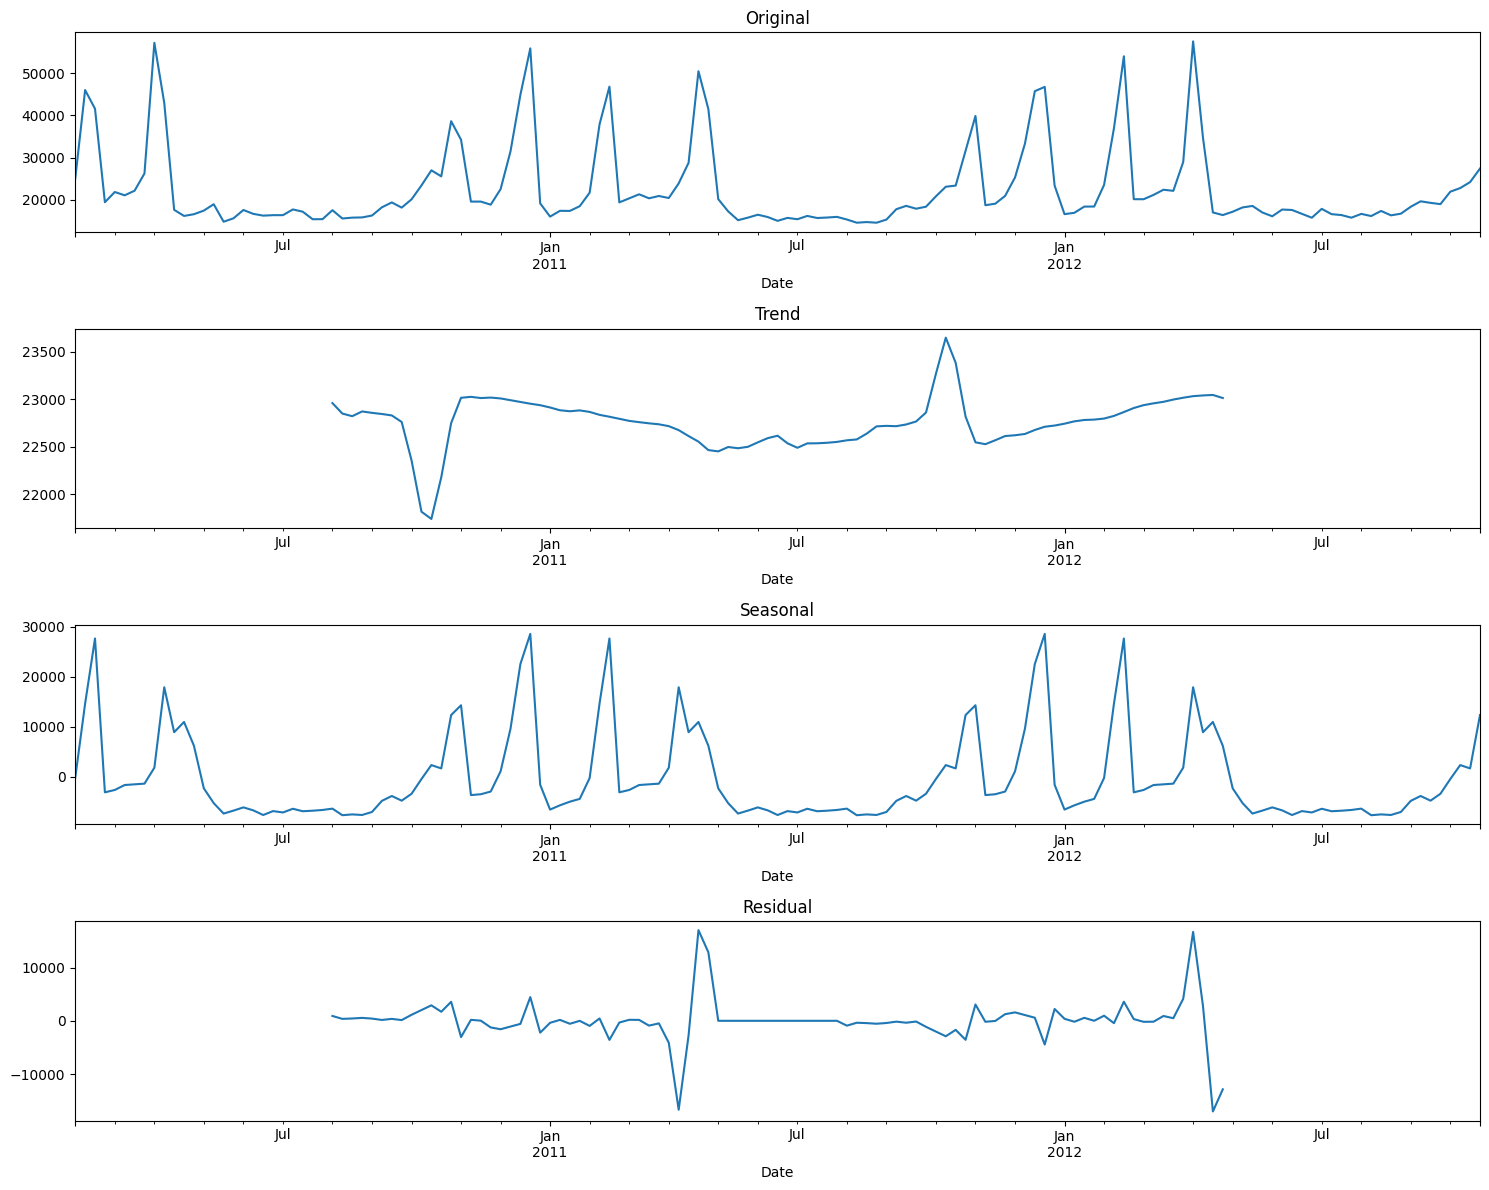

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Select a specific store-department combination for detailed analysis
sample_data = train[(train['Store'] == 1) & (train['Dept'] == 1)].copy()
sample_data = sample_data.set_index('Date').sort_index()

if len(sample_data) > 52:  # Need enough data points
    decomposition = seasonal_decompose(sample_data['Weekly_Sales'],
                                     model='additive', period=52)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0], title='Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.show()

In [16]:
def generate_insights_summary(train, stores, features):
    insights = {}

    # Basic statistics
    insights['total_stores'] = train['Store'].nunique()
    insights['total_departments'] = train['Dept'].nunique()
    insights['date_range'] = (train['Date'].min(), train['Date'].max())
    insights['total_weeks'] = train['Date'].nunique()

    # Sales statistics
    insights['avg_weekly_sales'] = train['Weekly_Sales'].mean()
    insights['total_sales'] = train['Weekly_Sales'].sum()
    insights['negative_sales_pct'] = (train['Weekly_Sales'] < 0).mean() * 100

    # Store insights
    if not stores.empty:
        insights['store_types'] = stores['Type'].value_counts().to_dict()
        insights['avg_store_size'] = stores['Size'].mean()

    return insights

insights = generate_insights_summary(train, stores, features)
for key, value in insights.items():
    print(f"{key}: {value}")

total_stores: 45
total_departments: 81
date_range: (Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))
total_weeks: 143
avg_weekly_sales: 15981.25812346704
total_sales: 6737218987.11
negative_sales_pct: 0.30481296107408024
store_types: {'A': 22, 'B': 17, 'C': 6}
avg_store_size: 130287.6
